# ¿De qué color pintarán el coche?

Una empresa dedicada a la venta de coches usados se enfrenta al desafío de determinar el color óptimo para repintar vehículos que llegan en condiciones deficientes. Tras
evaluar las opciones, decide limitarse a los colores blanco y negro, por ser los más comunes en el mercado. 

<p align="center">
    <p align="center">
        <img src="https://images.coches.com/_news_/2015/08/coche-blanco-coche-negro.jpg?w=1280&h=544" alt="Coches blancos y negros" width="600"/>
    </p>
</p>

Para decidir el color de repintado de cada coche, la empresa planea desarrollar un modelo predictivo que, basándose en las características de los vehículos en el mercado de segunda mano, determine si originalmente eran blancos o negros. 

La base de datos disponible incluye las siguientes variables independientes 
- Precio de venta, 
- Cantidad de Impuestos a pagar, 
- Fabricante, 
- Año de fabricación, 
- Categoría, 
- Interior de cuero, 
- Tipo de combustible, 
- Volumen del motor, 
- Kilometraje, 
- Cilindros, 
- Tipo de caja de cambios, 
- Ruedas motrices, 
- Lugar del volante, 
- Número de Airbags

Y de la variable dependiente 
- Color. 

La decisión final es si el coche debe pintarse de blanco o no.

## Inicialización de datos

### Librerías

In [1]:
                                                                       
import pandas as pd
import numpy as np
import re
from IPython.display import display  
import warnings

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Estadística
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Machine Learning sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Preprocesamiento de datos
from sklearn.model_selection import train_test_split, GridSearchCV

# Modelos de Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Modelos de Gradient Boosting
from xgboost import XGBClassifier

# Evaluación de los modelos
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

### Extracción y carga de datos

In [2]:
# Cargar los datos

df = pd.read_excel('datasets/datos_tarea25.xlsx')
display(df.head())

,Price,Levy,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
0,39493,891,HYUNDAI,2016,Jeep,Yes,Diesel,2,160931 km,4,Automatic,Front,Left wheel,White,4
1,1803,761,TOYOTA,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4,Automatic,Front,Left wheel,White,12
2,1098,394,TOYOTA,2014,Sedan,Yes,Hybrid,2.5,398069 km,4,Automatic,Front,Left wheel,Black,12
3,941,1053,MERCEDES-BENZ,2014,Sedan,Yes,Diesel,3.5,184467 km,6,Automatic,Rear,Left wheel,White,12
4,1019,1055,LEXUS,2013,Jeep,Yes,Hybrid,3.5,138038 km,6,Automatic,Front,Left wheel,White,12


## Pre-procesamiento de datos

Revisaremos valores ausentes, registros duplicados, tipos de datos, nombres de columnas.

In [3]:
# Revisamos información sobre el dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Price             4340 non-null   int64 
 1   Levy              4340 non-null   object
 2   Manufacturer      4340 non-null   object
 3   Prod. year        4340 non-null   int64 
 4   Category          4340 non-null   object
 5   Leather interior  4340 non-null   object
 6   Fuel type         4340 non-null   object
 7   Engine volume     4340 non-null   object
 8   Mileage           4340 non-null   object
 9   Cylinders         4340 non-null   int64 
 10  Gear box type     4340 non-null   object
 11  Drive wheels      4340 non-null   object
 12  Wheel             4340 non-null   object
 13  Color             4340 non-null   object
 14  Airbags           4340 non-null   int64 
dtypes: int64(4), object(11)
memory usage: 508.7+ KB


No observamos *valores ausentes* en los registros.

### Registros duplicados

In [4]:
# Revisión de duplicados
dupli = df.duplicated().sum()
print(f'Hay {dupli} registros duplicados de {len(df)} registros totales')
print(f'... el {((dupli / len(df))*100):.2f} % de registros duplicados')

Hay 1534 registros duplicados de 4340 registros totales
... el 35.35 % de registros duplicados


Eliminamos los registros duplicados encontrados:

In [5]:
# Eliminación de duplicados
df = df.drop_duplicates()
dupli = df.duplicated().sum()
print(f'Ahora hay {dupli} registros duplicados. Quedan {len(df)} registros')


Ahora hay 0 registros duplicados. Quedan 2806 registros


### Renombramos columnas:

In [6]:
def to_snake_case(name):
    # Reemplaza espacios en blanco por guion bajo
    name = re.sub(r'\s+', '_', name)
    # Elimina caracteres especiales excepto letras, números y guion bajo
    name = re.sub(r'[^A-Za-z0-9_]', '', name)
    # Convierte CamelCase/PascalCase a snake_case
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    snake = re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()
    # Reemplaza múltiples guiones bajos por uno solo
    snake = re.sub(r'_+', '_', snake)
    # Elimina guion bajo inicial o final si existe
    snake = snake.strip('_')
    # Elimina palabras repetidas consecutivas (ej: wheel_left_wheel -> wheel_left)
    parts = snake.split('_')
    deduped = [parts[0]]
    for part in parts[1:]:
        if part != deduped[-1]:
            deduped.append(part)
    snake = '_'.join(deduped)
    return snake

In [7]:
# Renombrar columnas a snake_case para estandarización
df = df.rename(columns = lambda x: to_snake_case(x))
df.columns.tolist()

['price',
 'levy',
 'manufacturer',
 'prod_year',
 'category',
 'leather_interior',
 'fuel_type',
 'engine_volume',
 'mileage',
 'cylinders',
 'gear_box_type',
 'drive_wheels',
 'wheel',
 'color',
 'airbags']

In [8]:
df.head()


,price,levy,manufacturer,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,wheel,color,airbags
0,39493,891,HYUNDAI,2016,Jeep,Yes,Diesel,2,160931 km,4,Automatic,Front,Left wheel,White,4
1,1803,761,TOYOTA,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4,Automatic,Front,Left wheel,White,12
2,1098,394,TOYOTA,2014,Sedan,Yes,Hybrid,2.5,398069 km,4,Automatic,Front,Left wheel,Black,12
3,941,1053,MERCEDES-BENZ,2014,Sedan,Yes,Diesel,3.5,184467 km,6,Automatic,Rear,Left wheel,White,12
4,1019,1055,LEXUS,2013,Jeep,Yes,Hybrid,3.5,138038 km,6,Automatic,Front,Left wheel,White,12


### Tipos de datos

In [9]:
# Revisión de tipos de datos
print('Revisión de tipos de datos por columna:')
print(df.dtypes)            

Revisión de tipos de datos por columna:
price                int64
levy                object
manufacturer        object
prod_year            int64
category            object
leather_interior    object
fuel_type           object
engine_volume       object
mileage             object
cylinders            int64
gear_box_type       object
drive_wheels        object
wheel               object
color               object
airbags              int64
dtype: object


In [10]:
# Revisemos valores/categorias en columnas de tipo object

columnas_object = df.select_dtypes(include='object').columns.tolist()

for column in columnas_object:
    print('column', column, ', unique values ', len(df[column].unique()))
    print(df[column].sort_values().unique())
    print()

column levy , unique values  203
['-' '1017' '1018' '1024' '1047' '1051' '1053' '1055' '1058' '1076' '1077'
 '1079' '1091' '1099' '1104' '1111' '1163' '11706' '11714' '1172' '1174'
 '1178' '1185' '1197' '1202' '1205' '1211' '1236' '1249' '1266' '1267'
 '1268' '1273' '1275' '1277' '1292' '1296' '1323' '1324' '1325' '1327'
 '1342' '1356' '1360' '1363' '1375' '1384' '1391' '1399' '1405' '1426'
 '1481' '1493' '1503' '1505' '1514' '1525' '1528' '1537' '1575' '1598'
 '1604' '1624' '1646' '1659' '1664' '1694' '1714' '1723' '175' '1750'
 '1793' '1811' '1817' '1820' '1823' '1845' '1848' '1850' '1935' '1946'
 '1951' '1968' '2002' '2018' '2056' '2070' '2108' '2148' '2151' '2188'
 '2223' '2225' '2265' '2266' '2297' '2364' '2410' '2418' '2455' '2570'
 '2705' '271' '2736' '2858' '2959' '3057' '308' '345' '3505' '353' '3571'
 '382' '394' '397' '420' '431' '441' '442' '456' '462' '463' '475' '501'
 '502' '503' '517' '518' '528' '530' '531' '552' '579' '583' '584' '585'
 '586' '595' '603' '605' '607' '

In [11]:
# Columna 'levy', cambiar a tipo entero
df['levy'] = pd.to_numeric(df['levy'], errors='coerce').astype('Int64')

In [12]:
df.isna().sum()

price                 0
levy                634
manufacturer          0
prod_year             0
category              0
leather_interior      0
fuel_type             0
engine_volume         0
mileage               0
cylinders             0
gear_box_type         0
drive_wheels          0
wheel                 0
color                 0
airbags               0
dtype: int64

Podemos observar que han surgido valores NaN en 'levy', entonces vamos a imputarlos más adelante.

In [13]:
# Columna 'leather_interior' cambio a tipo de dato binario
df['leather_interior'] = df['leather_interior'].map({'Yes': 1, 'No':0}) 
df['leather_interior'].unique()

array([1, 0])

In [14]:
df[df['engine_volume'].str.contains('Turbo', case=False, na=False)].head(5)

,price,levy,manufacturer,prod_year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,wheel,color,airbags
10,20385,<NA>,MERCEDES-BENZ,2006,Sedan,1,Diesel,2.2 Turbo,210000 km,4,Tiptronic,Rear,Left wheel,Black,8
43,72130,1079,LEXUS,2018,Jeep,1,Petrol,2.0 Turbo,18918 km,4,Tiptronic,Front,Left wheel,Black,6
81,31361,639,HYUNDAI,2014,Sedan,1,Petrol,2.0 Turbo,62000 km,4,Tiptronic,Front,Left wheel,White,12
101,84675,<NA>,MERCEDES-BENZ,2018,Sedan,1,Petrol,2.0 Turbo,4500 km,6,Tiptronic,Rear,Left wheel,Black,12
119,21953,<NA>,HYUNDAI,2013,Sedan,0,Hybrid,2.4 Turbo,20000 km,2,Tiptronic,Front,Right-hand drive,Black,4


In [15]:
# Crear columna 'turbo' a partir de 'engine_volume' y eliminar 'Turbo' de 'engine_volume' y convertir a tipo float
df.insert(df.columns.get_loc('engine_volume') + 1, 'turbo', df['engine_volume'].str.contains('Turbo', case=False, na=False).astype(int))
df['engine_volume'] = df['engine_volume'].str.replace('Turbo', '', case=False, regex=False).str.strip()
df['engine_volume'] = df['engine_volume'].astype(float)

In [16]:
df[df['turbo'] == 1].head()

,price,levy,manufacturer,prod_year,category,leather_interior,fuel_type,engine_volume,turbo,mileage,cylinders,gear_box_type,drive_wheels,wheel,color,airbags
10,20385,<NA>,MERCEDES-BENZ,2006,Sedan,1,Diesel,2.2,1,210000 km,4,Tiptronic,Rear,Left wheel,Black,8
43,72130,1079,LEXUS,2018,Jeep,1,Petrol,2.0,1,18918 km,4,Tiptronic,Front,Left wheel,Black,6
81,31361,639,HYUNDAI,2014,Sedan,1,Petrol,2.0,1,62000 km,4,Tiptronic,Front,Left wheel,White,12
101,84675,<NA>,MERCEDES-BENZ,2018,Sedan,1,Petrol,2.0,1,4500 km,6,Tiptronic,Rear,Left wheel,Black,12
119,21953,<NA>,HYUNDAI,2013,Sedan,0,Hybrid,2.4,1,20000 km,2,Tiptronic,Front,Right-hand drive,Black,4


In [17]:
# Revisamos la columna "mileage"
df.mileage.unique()

array(['160931 km', '258909 km', '398069 km', ..., '180234 km',
       '132700 km', '186923 km'], dtype=object)

In [18]:
# Columna mileage, eliminar la palabra " km" y convertir a tipo entero

df.mileage = df.mileage.str.replace(' km', '', regex=False)
df.mileage = pd.to_numeric(df.mileage, errors='coerce')
df.mileage.unique()


array([160931, 258909, 398069, ..., 180234, 132700, 186923])

In [19]:
df.head()

,price,levy,manufacturer,prod_year,category,leather_interior,fuel_type,engine_volume,turbo,mileage,cylinders,gear_box_type,drive_wheels,wheel,color,airbags
0,39493,891,HYUNDAI,2016,Jeep,1,Diesel,2.0,0,160931,4,Automatic,Front,Left wheel,White,4
1,1803,761,TOYOTA,2010,Hatchback,1,Hybrid,1.8,0,258909,4,Automatic,Front,Left wheel,White,12
2,1098,394,TOYOTA,2014,Sedan,1,Hybrid,2.5,0,398069,4,Automatic,Front,Left wheel,Black,12
3,941,1053,MERCEDES-BENZ,2014,Sedan,1,Diesel,3.5,0,184467,6,Automatic,Rear,Left wheel,White,12
4,1019,1055,LEXUS,2013,Jeep,1,Hybrid,3.5,0,138038,6,Automatic,Front,Left wheel,White,12


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2806 entries, 0 to 4339
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             2806 non-null   int64  
 1   levy              2172 non-null   Int64  
 2   manufacturer      2806 non-null   object 
 3   prod_year         2806 non-null   int64  
 4   category          2806 non-null   object 
 5   leather_interior  2806 non-null   int64  
 6   fuel_type         2806 non-null   object 
 7   engine_volume     2806 non-null   float64
 8   turbo             2806 non-null   int64  
 9   mileage           2806 non-null   int64  
 10  cylinders         2806 non-null   int64  
 11  gear_box_type     2806 non-null   object 
 12  drive_wheels      2806 non-null   object 
 13  wheel             2806 non-null   object 
 14  color             2806 non-null   object 
 15  airbags           2806 non-null   int64  
dtypes: Int64(1), float64(1), int64(7), object(7)
me

In [21]:
# Revisemos las columnas de tipo object que podrían convertirse a tipos numéricos o categóricos
print("Columnas tipo object:", columnas_object)
print()

for col in columnas_object:
    print(f"Columna: {col}")
    print(df[col].unique()[:10])  # Muestra los primeros 10 valores únicos
    print()

# Sugerencias:
# Convertir columnas seleccionadas a tipo 'category'

Columnas tipo object: ['levy', 'manufacturer', 'category', 'leather_interior', 'fuel_type', 'engine_volume', 'mileage', 'gear_box_type', 'drive_wheels', 'wheel', 'color']

Columna: levy
<IntegerArray>
[891, 761, 394, 1053, 1055, 1079, 810, 1850, 1249, <NA>]
Length: 10, dtype: Int64

Columna: manufacturer
['HYUNDAI' 'TOYOTA' 'MERCEDES-BENZ' 'LEXUS']

Columna: category
['Jeep' 'Hatchback' 'Sedan']

Columna: leather_interior
[1 0]

Columna: fuel_type
['Diesel' 'Hybrid' 'Petrol']

Columna: engine_volume
[2.  1.8 2.5 3.5 2.2 4.7 1.5 3.3 2.4 1.6]

Columna: mileage
[160931 258909 398069 184467 138038  76000  74146  54317 364523  39709]

Columna: gear_box_type
['Automatic' 'Tiptronic']

Columna: drive_wheels
['Front' 'Rear' '4x4']

Columna: wheel
['Left wheel' 'Right-hand drive']

Columna: color
['White' 'Black']



In [22]:
# Convertir columnas a tipo 'category'

categorical_cols = ['manufacturer', 'category', 'fuel_type', 'gear_box_type', 'drive_wheels', 'wheel', 'color']
df[categorical_cols] = df[categorical_cols].astype('category')
print(df[categorical_cols].dtypes)

manufacturer     category
category         category
fuel_type        category
gear_box_type    category
drive_wheels     category
wheel            category
color            category
dtype: object


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2806 entries, 0 to 4339
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             2806 non-null   int64   
 1   levy              2172 non-null   Int64   
 2   manufacturer      2806 non-null   category
 3   prod_year         2806 non-null   int64   
 4   category          2806 non-null   category
 5   leather_interior  2806 non-null   int64   
 6   fuel_type         2806 non-null   category
 7   engine_volume     2806 non-null   float64 
 8   turbo             2806 non-null   int64   
 9   mileage           2806 non-null   int64   
 10  cylinders         2806 non-null   int64   
 11  gear_box_type     2806 non-null   category
 12  drive_wheels      2806 non-null   category
 13  wheel             2806 non-null   category
 14  color             2806 non-null   category
 15  airbags           2806 non-null   int64   
dtypes: Int64(1), category(7), flo

### Valores ausentes

Imputaremos los valores NaN de la columna 'levy' usando la mediana de autos con las mismas características clave (categoría, año, fabricante y tipo de caja). Si no hay coincidencias, usa la mediana de autos con precio similar (+/- 5%) y, si aún no hay valor, la mediana general.


In [24]:
# Imputar valores NaN en 'levy' usando la mediana de coches con la misma category, prod_year, manufacturer y gear_box_type.
# Si no hay coincidencias, usar la mediana de coches con precio similar (+/- 5%).

def imputar_levy(row):
    if pd.isna(row['levy']):
        # Primer filtro: coincidencia exacta en 4 columnas
        filtro = (
            (df['category'] == row['category']) &
            (df['prod_year'] == row['prod_year']) &
            (df['manufacturer'] == row['manufacturer']) &
            (df['gear_box_type'] == row['gear_box_type']) &
            (~df['levy'].isna())
        )
        median_levy = df.loc[filtro, 'levy'].median()
        if not pd.isna(median_levy):
            return median_levy

        # Segundo filtro: coches con precio similar (+/- 5%)
        precio = row['price']
        margen = precio * 0.05
        filtro_precio = (
            (df['price'] >= precio - margen) &
            (df['price'] <= precio + margen) &
            (~df['levy'].isna())
        )
        median_levy_precio = df.loc[filtro_precio, 'levy'].median()
        if not pd.isna(median_levy_precio):
            return median_levy_precio

        # Tercer filtro: mediana general
        median_general = df['levy'].median()
        if not pd.isna(median_general):
            return median_general

        # Si todo falla, devuelve 0
        return 0
    else:
        return row['levy']

df['levy'] = df.apply(imputar_levy, axis=1)
df['levy'] = df['levy'].astype(int)

In [25]:
# Verificamos si hay valores NaN en 'levy'
print("Valores NaN en 'levy':", df['levy'].isna().sum())

Valores NaN en 'levy': 0


# Procesamiento de datos

En el procesamiento de datos realizaremos las siguientes tareas:

- Asegurarse de que todas las variables predictoras sean numéricas y no existan variables categóricas sin codificar.
- Eliminar columnas irrelevantes o redundantes para la predicción, en el caso que existan.
- Verificar que la variable objetivo esté correctamente codificada, en este caso respecto al color es (1=blanco, 0=negro).
- Revisar la multicolinealidad entre variables predictoras y eliminar variables altamente correlacionadas si es necesario.
- Separar el conjunto de datos en variables predictoras (X) y variable objetivo (y), y dividir los datos en conjuntos de entrenamiento, prueba y validación de modelo.
- Escalar o normalizar las variables numéricas si es necesario.

Vamos ha asegurarnos de que todas las variables predictoras sean numéricas y no existan variables categóricas sin codificar.

In [26]:
# Revisar la estructura y tipos de datos del DataFrame después del preprocesamiento.
df.info()
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
Index: 2806 entries, 0 to 4339
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   price             2806 non-null   int64   
 1   levy              2806 non-null   int64   
 2   manufacturer      2806 non-null   category
 3   prod_year         2806 non-null   int64   
 4   category          2806 non-null   category
 5   leather_interior  2806 non-null   int64   
 6   fuel_type         2806 non-null   category
 7   engine_volume     2806 non-null   float64 
 8   turbo             2806 non-null   int64   
 9   mileage           2806 non-null   int64   
 10  cylinders         2806 non-null   int64   
 11  gear_box_type     2806 non-null   category
 12  drive_wheels      2806 non-null   category
 13  wheel             2806 non-null   category
 14  color             2806 non-null   category
 15  airbags           2806 non-null   int64   
dtypes: category(7), float64(1), i

,price,levy,manufacturer,prod_year,category,leather_interior,fuel_type,engine_volume,turbo,mileage,cylinders,gear_box_type,drive_wheels,wheel,color,airbags
4332,22197,503,TOYOTA,2012,Hatchback,1,Petrol,1.5,0,50000,4,Automatic,Front,Left wheel,Black,4
4334,1176,986,TOYOTA,2010,Sedan,1,Hybrid,2.4,0,129170,4,Automatic,Front,Left wheel,Black,12
4335,470,831,HYUNDAI,2017,Sedan,1,Petrol,1.6,0,25635,4,Automatic,Front,Left wheel,Black,12
4336,26017,1624,LEXUS,2009,Sedan,1,Petrol,3.5,0,132700,4,Automatic,Front,Left wheel,White,4
4339,470,753,HYUNDAI,2012,Sedan,1,Hybrid,2.4,0,186923,4,Automatic,Front,Left wheel,White,12


### Codificación de variables categóricas

Usaremos One-HotEncoder para transformar las columnas categóricas en variables dummy (1 y 0). Parámetros usados:
- sparse_output=False: devuelve un array denso (numpy array), no una matriz dispersa (sparse matrix).
- handle_unknown='ignore': si aparecen categorías no vistas durante el ajuste, las ignora en vez de lanzar error.
- drop='first': elimina la primera categoría de cada variable para evitar multicolinealidad (dummy variable trap).

In [27]:
# Seleccion de columnas categóricas
col_cat = df.select_dtypes(include=['category']).columns.tolist()
col_cat 

['manufacturer',
 'category',
 'fuel_type',
 'gear_box_type',
 'drive_wheels',
 'wheel',
 'color']

In [28]:
# Selección de columnas categóricas para One-Hot Encoder
ohe = OneHotEncoder(sparse_output=False, 
                    handle_unknown='ignore',
                    drop='first')

# Ajustar el codificador OneHotEncoder a las columnas categóricas seleccionadas
col_ohe = ohe.fit_transform(df[col_cat])

# Transformar a dataframe las características OHE   
X_ohe = pd.DataFrame(data=col_ohe, columns=ohe.get_feature_names_out()).astype(int)

# Eliminar columnas categóricas "cat_col" en las características
df.drop(labels=col_cat, axis=1, inplace=True)

#  Agregar características OHE transformadas en características "df"
df = df.merge(right=X_ohe, left_index=True, right_index=True)

# Volver a renombrar columnas a snake_case
df = df.rename(columns = lambda x: to_snake_case(x))

# Revisar el DataFrame final
print("DataFrame final:")
display(df.head())   

# Guardar el DataFrame preprocesado en un archivo CSV
df.to_csv('datasets/datos_tarea25_preprocesado.csv', index=False)
print("DataFrame preprocesado guardado en 'datasets/datos_tarea25_preprocesado.csv'")

DataFrame final:


,price,levy,prod_year,leather_interior,engine_volume,turbo,mileage,cylinders,airbags,manufacturer_lexus,...,manufacturer_toyota,category_jeep,category_sedan,fuel_type_hybrid,fuel_type_petrol,gear_box_type_tiptronic,drive_wheels_front,drive_wheels_rear,wheel_righthand_drive,color_white
0,39493,891,2016,1,2.0,0,160931,4,4,0,...,0,1,0,0,0,0,1,0,0,1
1,1803,761,2010,1,1.8,0,258909,4,12,0,...,1,0,0,1,0,0,1,0,0,1
2,1098,394,2014,1,2.5,0,398069,4,12,0,...,1,0,1,1,0,0,1,0,0,0
3,941,1053,2014,1,3.5,0,184467,6,12,0,...,0,0,1,0,0,0,0,1,0,1
4,1019,1055,2013,1,3.5,0,138038,6,12,1,...,0,1,0,1,0,0,1,0,0,1


DataFrame preprocesado guardado en 'datasets/datos_tarea25_preprocesado.csv'


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1929 entries, 0 to 2804
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   price                      1929 non-null   int64  
 1   levy                       1929 non-null   int64  
 2   prod_year                  1929 non-null   int64  
 3   leather_interior           1929 non-null   int64  
 4   engine_volume              1929 non-null   float64
 5   turbo                      1929 non-null   int64  
 6   mileage                    1929 non-null   int64  
 7   cylinders                  1929 non-null   int64  
 8   airbags                    1929 non-null   int64  
 9   manufacturer_lexus         1929 non-null   int64  
 10  manufacturer_mercedesbenz  1929 non-null   int64  
 11  manufacturer_toyota        1929 non-null   int64  
 12  category_jeep              1929 non-null   int64  
 13  category_sedan             1929 non-null   int64  
 1

- Las columnas dummy indican la pertenencia a una categoría específica. Por ejemplo: `manufacturer_LEXUS = 1` significa que el auto es Lexus; `= 0` indica que es de la marca base (por ejemplo, Hyundai). Lo mismo aplica para el resto: `category_jeep`, `fuel_type_hybrid`, etc.

- En cada variable dummy, **1** indica que el auto pertenece a esa categoría, **0** indica que pertenece a la categoría base (la que no aparece como columna, definida por `drop='first'` en OneHotEncoder).

### Revisión de columnas irrelevantes o redundantes y variable objetivo

- No hay columnas redundantes hasta el momento. 
- La variable objetivo 'color_white' está correctamente codificada (1=blanco, 0=negro).


### Definimos variables: X, y 
Separaremos el conjunto de datos en variables predictoras (X) y variable objetivo (y); 

In [30]:
# Separar variables independientes (X) y variable objetivo (y)
X = df.drop('color_white', axis=1)
y = df['color_white']

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (1929, 20)
y shape: (1929,)


In [31]:
X.head()

,price,levy,prod_year,leather_interior,engine_volume,turbo,mileage,cylinders,airbags,manufacturer_lexus,manufacturer_mercedesbenz,manufacturer_toyota,category_jeep,category_sedan,fuel_type_hybrid,fuel_type_petrol,gear_box_type_tiptronic,drive_wheels_front,drive_wheels_rear,wheel_righthand_drive
0,39493,891,2016,1,2.0,0,160931,4,4,0,0,0,1,0,0,0,0,1,0,0
1,1803,761,2010,1,1.8,0,258909,4,12,0,0,1,0,0,1,0,0,1,0,0
2,1098,394,2014,1,2.5,0,398069,4,12,0,0,1,0,1,1,0,0,1,0,0
3,941,1053,2014,1,3.5,0,184467,6,12,0,1,0,0,1,0,0,0,0,1,0
4,1019,1055,2013,1,3.5,0,138038,6,12,1,0,0,1,0,1,0,0,1,0,0


### Multicolinealidad y alta correlación

Vamos a revisar la multicolinealidad entre variables predictoras y variables altamente correlacionadas.

Para ello realizaremos el análisis de correlación y el cálculo del VIF (Variance Inflation Factor), que son herramientas complementarias para identificar redundancias y relaciones lineales entre variables predictoras:

- **Matriz de correlación:** Permite detectar pares de variables que están fuertemente relacionadas entre sí. Por ejemplo, si `engine_volume` y `cylinders` tienen una correlación alta, significa que ambas variables aportan información muy similar al modelo.

- **VIF:** Evalúa la multicolinealidad de cada variable respecto a todas las demás. Un VIF alto (usualmente >5 o >10) indica que una variable puede ser explicada en gran parte por una combinación lineal de las otras, lo que puede distorsionar la interpretación y el desempeño del modelo.

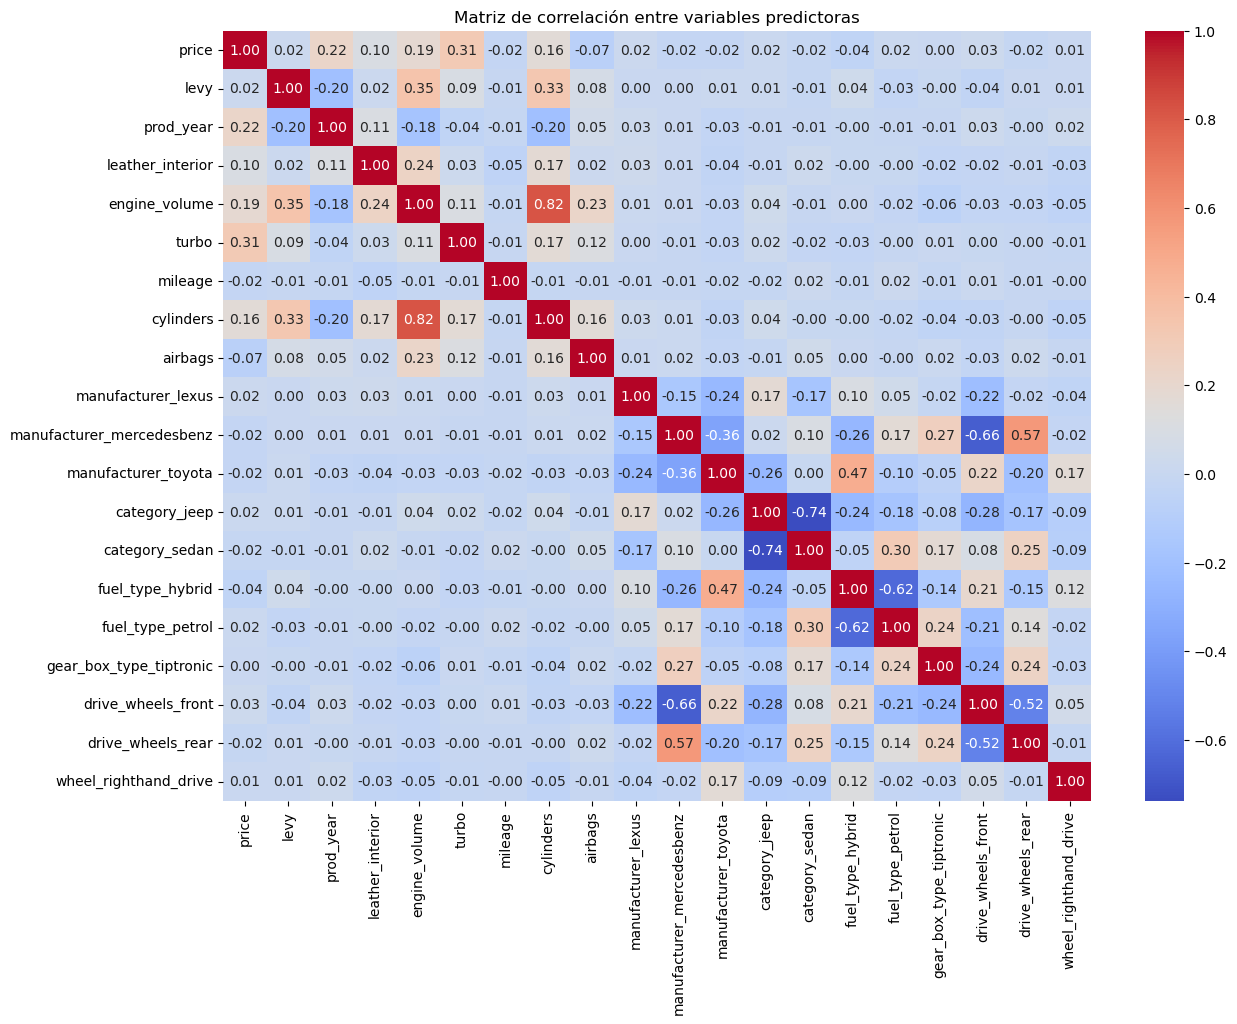

,feature,VIF
2,prod_year,62.551442
7,cylinders,43.561961
4,engine_volume,26.431105
17,drive_wheels_front,10.994031
15,fuel_type_petrol,6.008894
3,leather_interior,5.878004
13,category_sedan,5.876294
12,category_jeep,5.781895
8,airbags,4.541423
14,fuel_type_hybrid,4.352600


In [32]:
# 1. Matriz de correlación
plt.figure(figsize=(14,10))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlación entre variables predictoras")
plt.show()

# 2. Calcular VIF para cada variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# 3. Mostrar VIF  
display(vif_data.sort_values("VIF", ascending=False))

# Si encuentras variables con VIF alto o correlación alta, considera eliminarlas y vuelve a calcular.

# ¿Qué significa el VIF?
# El VIF (Variance Inflation Factor, o Factor de Inflación de la Varianza) mide cuánto se incrementa la varianza de los coeficientes de una regresión debido a la multicolinealidad entre las variables predictoras.
# Un VIF = 1 indica que no hay correlación entre esa variable y las demás.
# Un VIF > 5 sugiere una multicolinealidad moderada a alta (algunos autores usan el umbral de 10).
# Si el VIF de una variable es alto (mayor a 5 o 10), significa que esa variable está altamente correlacionada con otras y puede distorsionar los resultados del modelo.


### Análisis de correlación y multicolinealidad (VIF), y eliminación de variables

El umbral a usar para considerar un VIF alto y una alta correlación son:
-  VIF alto > 10
-  alta correlación > 0.75

Esto ayuda a reducir la multicolinealidad y mejora la interpretabilidad y robustez del modelo predictivo. Tras cada eliminación, es importante recalcular el VIF para verificar que no persistan problemas de multicolinealidad.

Variables eliminadas: ['drive_wheels_front', 'prod_year', 'engine_volume', 'cylinders']
Nueva forma de X: (1929, 16)


,feature,VIF
12,fuel_type_petrol,4.850748
2,leather_interior,4.697327
10,category_sedan,4.202804
5,airbags,3.827484
11,fuel_type_hybrid,3.572499
8,manufacturer_toyota,3.171581
9,category_jeep,2.689774
7,manufacturer_mercedesbenz,2.295369
1,levy,2.108822
0,price,1.927220


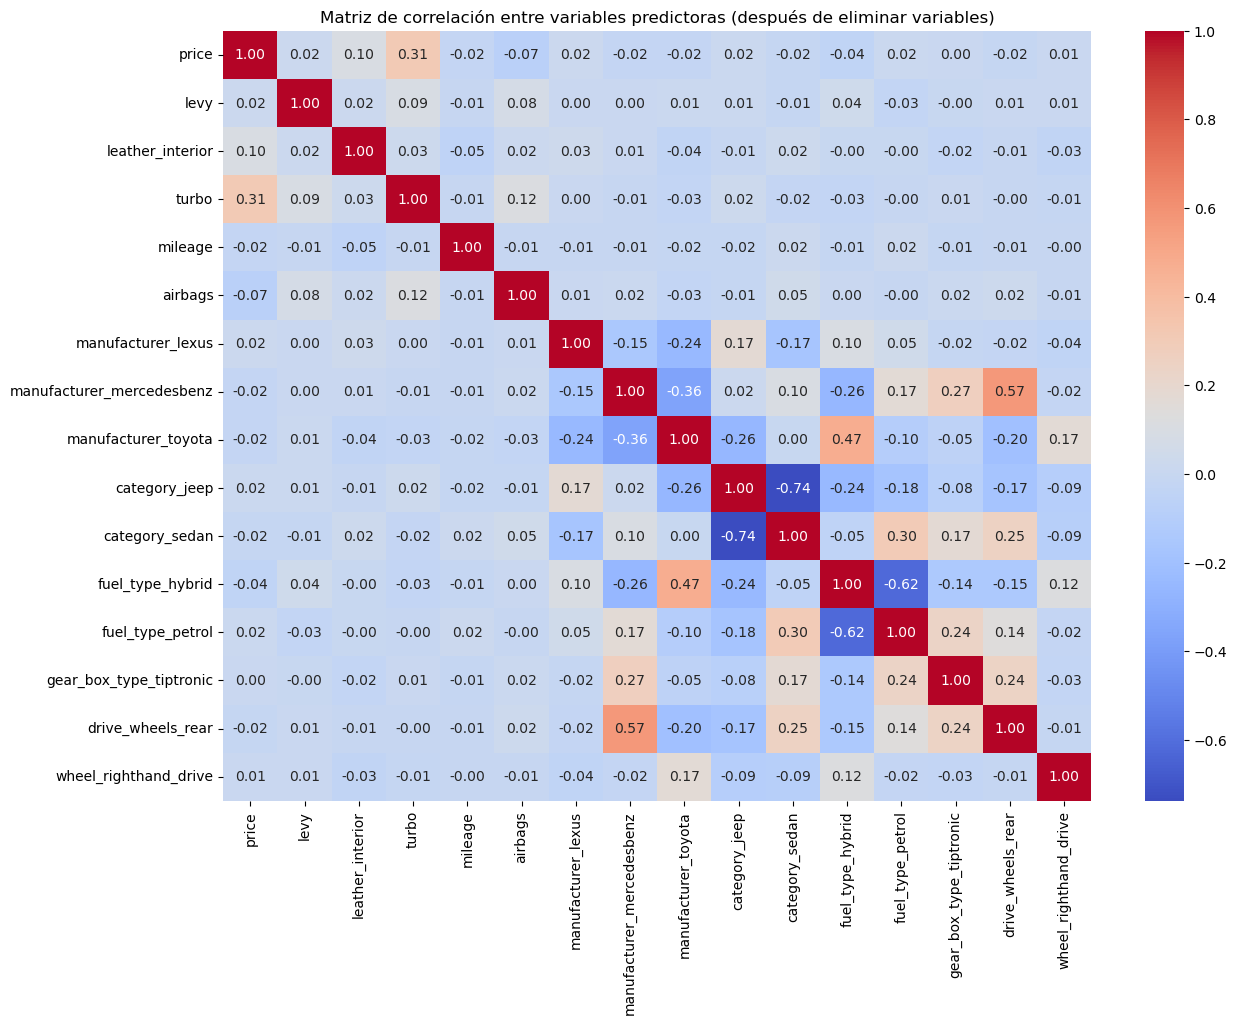

In [33]:
# Automatización de selección de columnas a eliminar por VIF y correlación

# 1. Eliminar variables con VIF alto

vif_threshold = 10 # Umbral para considerar VIF alto
high_vif_cols = vif_data[vif_data["VIF"] > vif_threshold]["feature"].tolist()

# 2. Eliminar una de cada par de variables con correlación alta
corr_matrix = X.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)
corr_threshold = 0.75   # Umbral para considerar correlación alta (>=0.75 o <=-0.75)
to_drop_corr = [
    column for column in upper.columns if any(upper[column] > corr_threshold)
]

# 3. Unir y eliminar duplicados
vars_to_drop = list(set(high_vif_cols + to_drop_corr))
X = X.drop(vars_to_drop, axis=1)

print("Variables eliminadas:", vars_to_drop)
print("Nueva forma de X:", X.shape)

# 4. Recalcular VIF y correlación
# Recalcular Correlación 
plt.figure(figsize=(14,10))
plt.title("Matriz de correlación entre variables predictoras (después de eliminar variables)")
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm")

# Recalcular VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
display(vif_data.sort_values("VIF", ascending=False))


### Segmentación de datos: train, test

Realizaremos la segmentación de datos para el entrenamiento y prueba de modelos, con proporciones en proporciones 75/25 correspondientemente.

Las variables las llamaremos de la siguiente manera:
* entrenamiento X_train, y_train
* prueba X_test, y_test


In [34]:
# Primero, separamos el 75% para entrenamiento y el 25% para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345, stratify=y)

print('train:', X_train.shape, y_train.shape)
print('test: ', X_test.shape, y_test.shape)

train: (1446, 16) (1446,)
test:  (483, 16) (483,)


### Escalar variables numéricas

El escalado o normalizado de variables numéricas es fundamental porque muchos algoritmos de machine learning son sensibles a la magnitud de los datos. Si las variables tienen escalas muy diferentes, aquellas con valores más grandes pueden dominar el proceso de aprendizaje, afectando la precisión y la interpretación del modelo. Al escalar, aseguramos que cada variable aporte de manera equilibrada, mejorando la convergencia, el desempeño y la estabilidad de los modelos predictivos.

In [35]:
# Backup de datos no escalados
X_train_unscaled = X_train.copy()
X_test_unscaled  = X_test.copy()

In [36]:
X_train.head()

,price,levy,leather_interior,turbo,mileage,airbags,manufacturer_lexus,manufacturer_mercedesbenz,manufacturer_toyota,category_jeep,category_sedan,fuel_type_hybrid,fuel_type_petrol,gear_box_type_tiptronic,drive_wheels_rear,wheel_righthand_drive
2420,17484,583,1,0,103453,4,0,0,1,0,1,0,1,1,0,0
889,12858,586,0,0,120000,9,0,0,1,0,0,1,0,0,0,1
116,11917,530,1,0,31691,4,1,0,0,1,0,0,1,0,0,0
1747,40,585,0,0,123000,2,0,0,0,0,1,0,1,0,0,0
1013,392,761,1,0,408997,12,0,0,1,1,0,0,1,0,0,0


In [37]:
# Función para seleccionar automáticamente columnas numéricas a escalar
def get_numeric_columns_to_scale(df, exclude_binary=True, threshold_unique=10):
    """
    Devuelve una lista de columnas numéricas a escalar.
    Por defecto excluye columnas binarias (con solo 2 valores únicos) y columnas con pocos valores únicos.
    """
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cols_to_scale = []
    for col in numeric_cols:
        n_unique = df[col].nunique()
        if exclude_binary and n_unique <= 2:
            continue
        if n_unique < threshold_unique:
            continue
        cols_to_scale.append(col)
    return cols_to_scale

In [38]:
cols_to_scale = get_numeric_columns_to_scale(X_train)

scaler = StandardScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
# Escalar las mismas columnas en el conjunto de prueba usando el mismo scaler de entrenamiento
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

# Revisar el DataFrame después del escalado
print("DataFrames después del escalado:")
print("--Primeras filas de X_train y sus estadísticas descriptivas:")
display(X_train.head())
display(X_train[cols_to_scale].describe())
print("--Primeras filas de X_test y sus estadísticas descriptivas:")
display(X_test.head())
display(X_test[cols_to_scale].describe())


DataFrames después del escalado:
--Primeras filas de X_train y sus estadísticas descriptivas:


,price,levy,leather_interior,turbo,mileage,airbags,manufacturer_lexus,manufacturer_mercedesbenz,manufacturer_toyota,category_jeep,category_sedan,fuel_type_hybrid,fuel_type_petrol,gear_box_type_tiptronic,drive_wheels_rear,wheel_righthand_drive
2420,-0.216201,-0.424788,1,0,-0.027112,-0.836323,0,0,1,0,1,0,1,1,0,0
889,-0.376388,-0.421456,0,0,-0.026546,0.342814,0,0,1,0,0,1,0,0,0,1
116,-0.408973,-0.483650,1,0,-0.029569,-0.836323,1,0,0,1,0,0,1,0,0,0
1747,-0.820246,-0.422567,0,0,-0.026443,-1.307977,0,0,0,0,1,0,1,0,0,0
1013,-0.808057,-0.227101,1,0,-0.016651,1.050296,0,0,1,1,0,0,1,0,0,0


,price,levy,mileage,airbags
count,1.446000e+03,1.446000e+03,1446.000000,1.446000e+03
mean,-4.913850e-18,4.422465e-17,0.000000,4.176773e-17
std,1.000346e+00,1.000346e+00,1.000346,1.000346e+00
min,-8.214229e-01,-8.779127e-01,-0.030654,-1.779632e+00
25%,-5.487908e-01,-3.614835e-01,-0.028569,-8.363227e-01
50%,-1.700424e-01,-2.048889e-01,-0.026686,1.069867e-01
75%,2.643267e-01,9.941563e-02,-0.024834,1.050296e+00
max,2.089752e+01,1.193730e+01,38.012892,1.993605e+00


--Primeras filas de X_test y sus estadísticas descriptivas:


,price,levy,leather_interior,turbo,mileage,airbags,manufacturer_lexus,manufacturer_mercedesbenz,manufacturer_toyota,category_jeep,category_sedan,fuel_type_hybrid,fuel_type_petrol,gear_box_type_tiptronic,drive_wheels_rear,wheel_righthand_drive
1964,-0.094035,-0.545843,0,0,-0.026374,-0.128841,0,0,0,0,1,0,1,0,0,0
875,-0.190023,-0.309285,1,0,-0.028860,-0.836323,0,0,1,0,1,0,1,0,0,0
2059,0.176684,-0.485871,1,0,-0.027545,-0.836323,0,0,0,1,0,0,0,0,0,0
1259,-0.213500,-0.207110,0,0,-0.025850,-1.779632,0,0,1,0,0,1,0,0,1,1
251,-0.479544,-0.558060,1,0,-0.030654,1.050296,0,0,1,0,1,0,1,1,0,0


,price,levy,mileage,airbags
count,483.000000,483.000000,483.000000,483.000000
mean,0.011238,0.024982,-0.026508,-0.039978
std,0.778990,1.057041,0.002773,1.003836
min,-0.821319,-0.771295,-0.030654,-1.779632
25%,-0.506277,-0.355931,-0.028386,-0.836323
50%,-0.119867,-0.204889,-0.026820,0.106987
75%,0.353545,0.099416,-0.025264,1.050296
max,7.974620,11.937305,-0.007480,1.993605


## Balanceo de clases

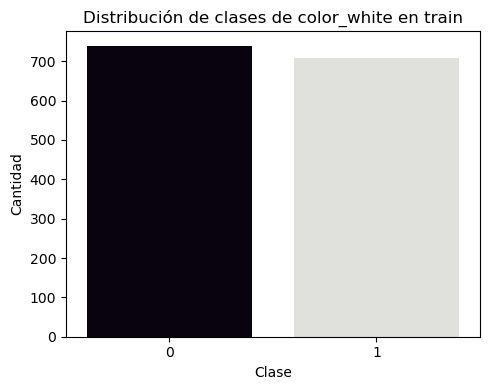

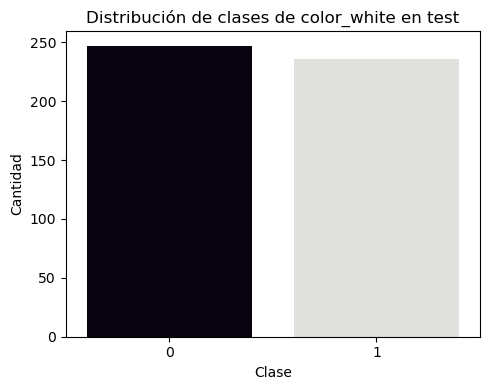

In [39]:
# Función para mostrar la distribución de clases

def plots(data, title):
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.barplot(
        x=data.value_counts().index,
        y=data.value_counts().values,
        palette=["#090111", "#E0E0DD"],
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Clase')
    ax.set_ylabel('Cantidad')
    plt.tight_layout()
    plt.show()

warnings.filterwarnings('ignore')

# Elimina las llamadas a plt.title, plt.xlabel, plt.ylabel fuera de la función

plots(y_train, title='Distribución de clases de color_white en train')
plots(y_test, title='Distribución de clases de color_white en test')


Las clases en los conjuntos de entrenamiento (`y_train`) y prueba (`y_test`) ya se encuentran balanceadas, lo que significa que la proporción de autos blancos y no blancos es similar en ambos conjuntos. Esto es importante para asegurar que los modelos predictivos no estén sesgados hacia una clase y puedan generalizar correctamente.

# Entrenamiento 

### Bibliotecas

#### Diccionario de hiperparámetros

In [40]:
# Hyperparameter dictionaries

# LogisticRegression
# - `penalty`: La norma utilizada en la regularización. Las opciones son “l1” para la regularización L1 (valor absoluto) y 
#              “l2” para la regularización L2 (cuadrados).
# - `C`: La inversa de la fuerza de regularización. Valores más pequeños especifican una regularización más fuerte.
# - `solver`: Optimiza los parámetros. Las opciones son: “liblinear”, “saga”, “newton-cg”, “lbfgs” y “sag”. 
#             El solucionador “liblinear” es bueno para conjuntos de datos pequeños, mientras que los solucionadores “sag” y “saga” 
#             son más rápidos para conjuntos de datos grandes.
# - `max_iter`: El número máximo de iteraciones permitidas para la convergencia del solucionador.

params_lr = {'penalty': ['l1', 'l2'],
             'C': [0.01, 0.1, 1.0],
             'solver': ['liblinear', 'saga'],
             'max_iter': [500, 1000]}

# DecisionTreeClassifier
# - `criterion`: La función de medición de calidad utilizada para dividir los nodos. Las opciones son “gini” para la impureza de Gini, 
#                y "entropy" y "log_loss" ambos para la ganancia de información de Shannon.
# - `max_depth`: La profundidad máxima del árbol. Si se establece en “None”, los nodos se expandirán hasta que todas las hojas contengan menos de min_samples_split muestras.
# - `min_samples_split`: El número mínimo de muestras requeridas para dividir un nodo interno.
# - `min_samples_leaf`: El número mínimo de muestras requeridas para estar en una hoja.

params_dt = {'criterion': ['gini', 'entropy', 'log_loss'],
             'max_depth': [None, 5, 10],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}

# RandomForestClassifier
# - `n_estimators`: El número de árboles en el bosque.
# - `max_features`: El número máximo de características que se consideran para dividir un nodo.
# - `max_depth`: La profundidad máxima del árbol.
# - `min_samples_split`: El número mínimo de muestras requeridas para dividir un nodo interno.
# - `min_samples_leaf`: El número mínimo de muestras requeridas para estar en un nodo hoja.

params_rf = {'n_estimators': [100, 200, 500],
             'max_depth': [5, 10, 20],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4],
             'max_features': ['sqrt', 'log2']}

# XGBClassifier
# - `n_estimators`: El número de árboles en el bosque.
# - `max_depth`: La profundidad máxima del árbol.
# - `learning_rate`: Tasa de aprendizaje utilizada para actualizar los pesos con cada iteración.
# - `subsample`: La fracción de muestras utilizadas para entrenar cada árbol.
# - `colsample_bytree`: La fracción de características utilizadas para entrenar cada árbol.

params_xgb = {'n_estimators': [100, 200, 500],
              'max_depth': [5, 10, 20],
              'learning_rate': [0.01, 0.1, 1.0],
              'subsample': [0.5, 0.8, 1.0],
              'colsample_bytree': [0.5, 0.8, 1.0]}

# LGBMClassifier
# - `n_estimators`: El número de árboles en el bosque.
# - `max_depth`: La profundidad máxima del árbol.
# - `learning_rate`: Tasa de aprendizaje utilizada para actualizar los pesos con cada iteración.
# - `subsample`: La fracción de muestras utilizadas para entrenar cada árbol.
# - `colsample_bytree`: La fracción de características utilizadas para entrenar cada árbol.

params_lgbm = {'n_estimators': [100, 200, 500],
               'max_depth': [5, 10, 20],
               'learning_rate': [0.01, 0.1, 1.0],
               'subsample': [0.5, 0.8, 1.0],
               'colsample_bytree': [0.5, 0.8, 1.0]}


# CatBoostClassifier
# - `iterations`: El número máximo de iteraciones a realizar.
# - `depth`: La profundidad máxima del árbol.
# - `learning_rate`: Tasa de aprendizaje utilizada para actualizar los pesos con cada iteración.
# - `subsample`: La fracción de muestras utilizadas para entrenar cada árbol.
# - `colsample_bylevel`: La fracción de características utilizadas para entrenar cada árbol.

params_cb = {'iterations': [100, 200, 500],
             'depth': [5, 10, 16],
             'learning_rate': [0.01, 0.2],
             'subsample': [0.5, 0.8, 1.0],
             'colsample_bylevel': [0.5, 0.8]}


# KNeighborsClassifier
# - `n_neighbors`: El número de vecinos a considerar al clasificar una muestra.
# - `weights`: Función utilizada para ponderar los vecinos. Las opciones son ‘uniforme’ y ‘distancia’.
# - `algorithm`: Algoritmo utilizado para calcular los vecinos más cercanos. Las opciones son ‘auto’, ‘ball_tree’, ‘kd_tree’ y ‘brute’.

params_knb = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# MLPClassifier

# - `hidden_layer_sizes`: una tupla que representa el número de neuronas en cada capa oculta. 
#                         Por ejemplo, (50, 50) significa que hay dos capas ocultas con 50 neuronas cada una.
# - `activation`: la función de activación para la capa oculta. Las opciones son 'identity', 'logistic', 'tanh' y 'relu'.
# - `solver`: el algoritmo de optimización para actualizar los pesos. Las opciones son 'lbfgs', 'sgd' y 'adam'.
# - `alpha`: parámetro de regularización para controlar el sobreajuste. Los valores más altos significan una mayor regularización.
# - `learning_rate`: la tasa de aprendizaje para actualizar los pesos. Las opciones son 'constant', 'invscaling' y 'adaptive'.

params_mlp = {
    'hidden_layer_sizes': [(50,100,50),(100, 200, 100)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.04],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [1000]
}

# SVC
# - `C`: La inversa de la fuerza de regularización. Valores más pequeños especifican una regularización más fuerte.
# - `kernel`: El tipo de kernel a usar. Las opciones son 'linear', 'poly', 'rbf' y 'sigmoid'.
# - `gamma`: El coeficiente del kernel. Valores más altos pueden llevar a un sobreajuste.
# - `degree`: El grado del polinomio si se usa el kernel polinómico. Solo relevante si `kernel='poly'`.
# - `coef0`: Término independiente en el kernel polinómico y sigmoide. Solo relevante si `kernel='poly'` o `kernel='sigmoid'`.
params_svc = {
    'C': [0.01, 0.1, 1.0],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [3, 5],
    'coef0': [0.0, 0.1]
}

# XGBClassifier
# - `n_estimators`: El número de árboles en el bosque.
# - `max_depth`: La profundidad máxima del árbol.               
# - `learning_rate`: Tasa de aprendizaje utilizada para actualizar los pesos con cada iteración.
# - `subsample`: La fracción de muestras utilizadas para entrenar cada árbol.
# - `colsample_bytree`: La fracción de características utilizadas para entrenar cada    árbol.                  
# - `reg_alpha`: Término de regularización L1.
# - `reg_lambda`: Término de regularización L2.
params_xgb = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],       
    'learning_rate': [0.01, 0.1, 1.0],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1],
    
}


#### Función: grid_search

In [41]:
# Funcion grid_search para encontrar mejores parámetros


def grid_search_cv(estimator, params, X, y):
    '''
    parameters:
    "estimator": algorithm to train
    "params": hyperparameters
    "x": features train
    "y": target train
    return: the best parameters
    '''
  
    grid_search= GridSearchCV(estimator=estimator, param_grid=params, scoring='roc_auc', cv=5, error_score='raise')
    grid_search.fit(X, y)
    best_params  = grid_search.best_params_

    print(f'Best hiperparameters: {best_params}')
    return best_params

#### Función: model_evaluator

In [42]:
# Function model_evaluator for to evaluate each model and to Graph results

def model_evaluator(model, X_train, y_train, X_test, y_test):

    '''
    parameters:    
      model: model previously trained and with hyperparameter tuning
      X_train, y_train: features and target dataset train
      X_test, y_test: features and target dataset test
    calculate metrics accuracy and roc_auc
    show graphs
    return the values for accuracy and ROC-AUC
    '''
    
    results_metrics = pd.DataFrame(columns=['group', 'accuracy', 'f1', 'roc_auc']).set_index(keys=['group'])
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5)) 

    
    for group, X, y in (('train', X_train, y_train), ('test', X_test, y_test)):
        # Predictions
        y_prediction = model.predict(X)
        y_prediction_proba = model.predict_proba(X)[:, 1] # Probabilities of the positive class

        # METRICS Accuracy and ROC AUC
        accuracy = round(accuracy_score(y, y_prediction), 2)
        roc_auc = round(roc_auc_score(y, y_prediction_proba),2)  
        f1      = round(f1_score(y, y_prediction), 2)

        results_metrics.loc[group] = {'accuracy':accuracy, 'f1':f1, 'roc_auc':roc_auc} 
        # ----------------------------------------------------------------------------------------------------------------------

        # PLOTS
        color = 'blue' if group == 'train' else 'orange'

        # axs[0] = Accuracy
        ax= axs[0]

        accuracy_thresholds = np.arange(0, 1.01, 0.05) # [0.0, 0.05, 0.10, 0.15, 0.20, ... , 1.0]
        accuracy_scores = [accuracy_score(y, y_prediction_proba>=threshold) for threshold in accuracy_thresholds]

        max_accuracy_score_idx = np.argmax(accuracy_scores)
        ax.plot(accuracy_thresholds, accuracy_scores, color=color, 
                label=f'{group}, max={accuracy_scores[max_accuracy_score_idx]:.2f} @ {accuracy_thresholds[max_accuracy_score_idx]:.2f}')
        
        # Defining crosses for some thresholds    
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(accuracy_thresholds-threshold))
            marker_color = 'green' if threshold != 0.5 else 'red'
            ax.plot(accuracy_thresholds[closest_value_idx], accuracy_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('Accuracy')
        ax.legend(loc='lower center')
        ax.set_title(f'Accuracy') 

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [f1_score(y, y_prediction_proba >= threshold) for threshold in f1_thresholds]

        # axs[1] = F1
        ax = axs[1]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{group}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        
        # Defining crosses for some thresholds         
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'green' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1') 

        # axs[2] = ROC-CURVE
        ax = axs[2]   
        fpr, tpr, roc_thresholds = roc_curve(y, y_prediction_proba)

        ax.plot(fpr, tpr, color=color, label=f'{group}, ROC AUC={roc_auc:.2f}')
        
        # Defining crosses for some thresholds  
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'green' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        
        ax.plot([0, 1], [0, 1], color='black', linestyle='--')
        
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate (FPR)')
        ax.set_ylabel('True Positive Rate (TPR)')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')

    display(results_metrics)
   
    return results_metrics

## Modelo 1: Regresión logistica

In [43]:
# Tuning hyperparameters:
best_params_lr = grid_search_cv(LogisticRegression(random_state=12345), params_lr, X_train, y_train)

Best hiperparameters: {'C': 1.0, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}


,accuracy,f1,roc_auc
group,,,
train,0.62,0.63,0.68
test,0.59,0.59,0.63


CPU times: user 218 ms, sys: 28 μs, total: 218 ms
Wall time: 216 ms


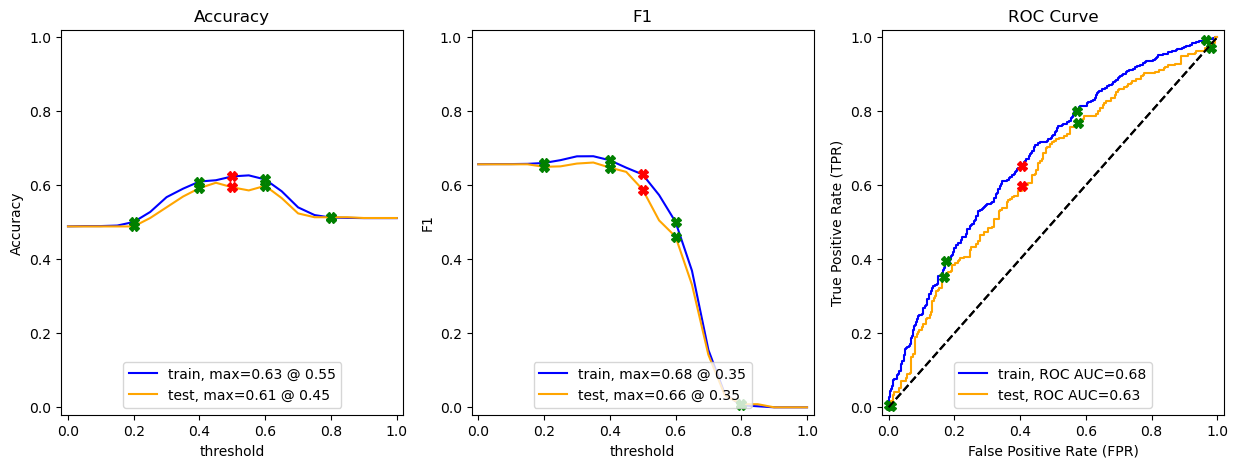

In [44]:
%%time
# Entrenamiento del modelo LogisticRegression con los mejores hiperparámetros encontrados en best_params_lr
model_lr = LogisticRegression(
    random_state=12345,
    penalty='l2',
    C=1.0,
    solver='saga',
    max_iter=500
)
# Entrenar el modelo
model_lr.fit(X_train, y_train)

# Evaluación del modelo
result_lr = model_evaluator(model_lr, X_train, y_train, X_test, y_test)

## Modelo 2: Árbol de decisión

In [45]:
# Tuning hyperparameters:
# params_dt = grid_search_cv(DecisionTreeClassifier(random_state=12345), params_dt, X_train, y_train)

,accuracy,f1,roc_auc
group,,,
train,0.66,0.65,0.71
test,0.55,0.52,0.59


CPU times: user 139 ms, sys: 4.1 ms, total: 143 ms
Wall time: 142 ms


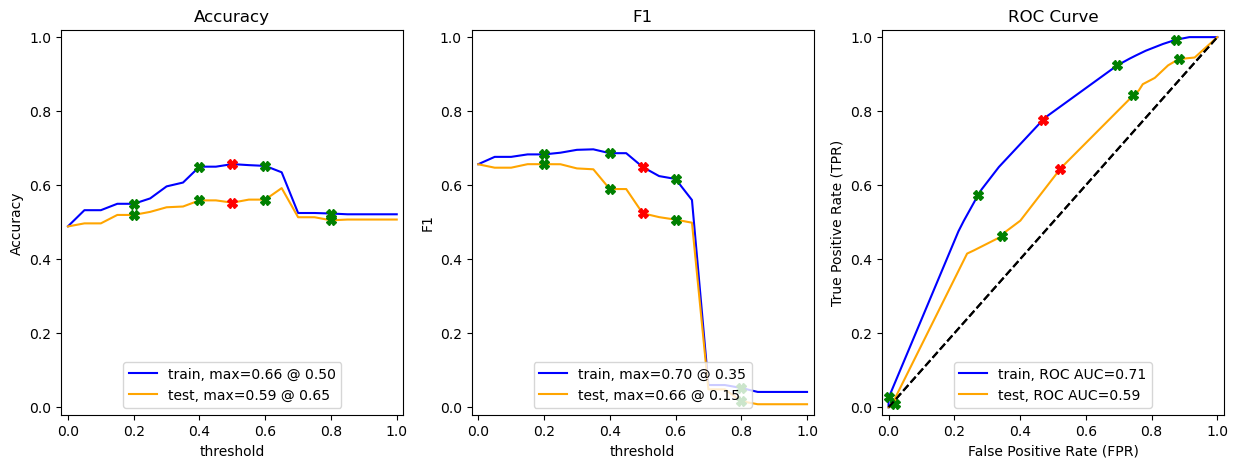

In [46]:
%%time
# Entrenamiento del modelo DecisionTreeClassifier con los mejores hiperparámetros encontrados en params_dt
model_dt = DecisionTreeClassifier(
    random_state=12345,
    criterion='entropy',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1
)
# Entrenar el modelo
model_dt.fit(X_train, y_train)
# Evaluación del modelo
result_dt = model_evaluator(model_dt, X_train, y_train, X_test, y_test)

## Modelo 3: Random Forest

In [47]:
# Tuning hyperparameters:
# params_rf = grid_search_cv(RandomForestClassifier(random_state=12345), params_rf, X_train, y_train)

,accuracy,f1,roc_auc
group,,,
train,0.67,0.65,0.76
test,0.60,0.55,0.64


CPU times: user 458 ms, sys: 7.9 ms, total: 466 ms
Wall time: 466 ms


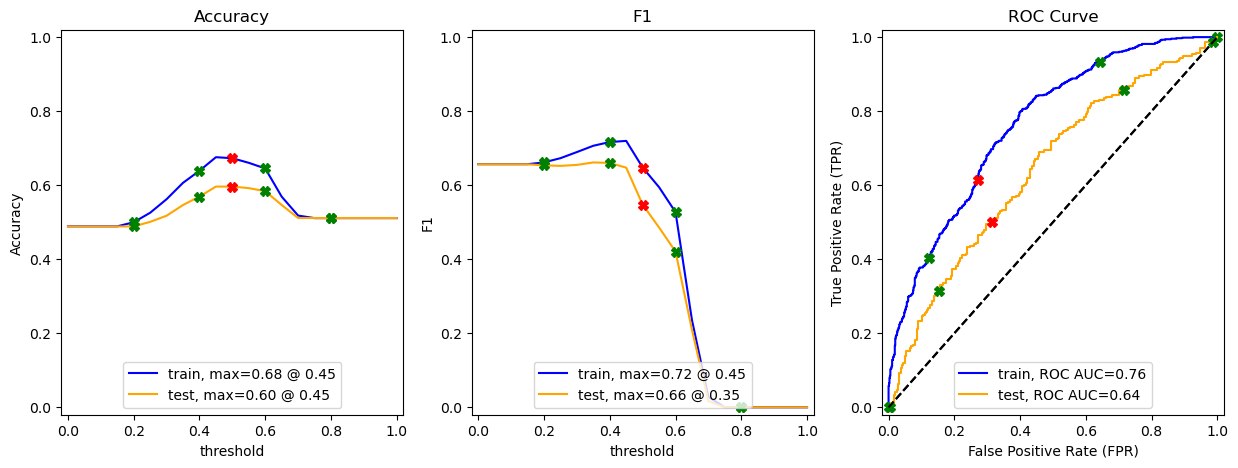

In [48]:
%%time
# Entrenamiento del modelo RandomForestClassifier con los mejores hiperparámetros encontrados en best_params_rf
model_rf = RandomForestClassifier(
    random_state=12345,
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt'
)

# Entrenar el modelo
model_rf.fit(X_train, y_train)

# Evaluación del modelo
result_rf = model_evaluator(model_rf, X_train, y_train, X_test, y_test)

## Modelo 4: SVC

In [49]:
# Tuning hyperparameters:
# params_svc = grid_search_cv(SVC(random_state=12345), params_svc, X_train, y_train)

,accuracy,f1,roc_auc
group,,,
train,0.62,0.64,0.67
test,0.62,0.64,0.64


CPU times: user 529 ms, sys: 16 ms, total: 545 ms
Wall time: 544 ms


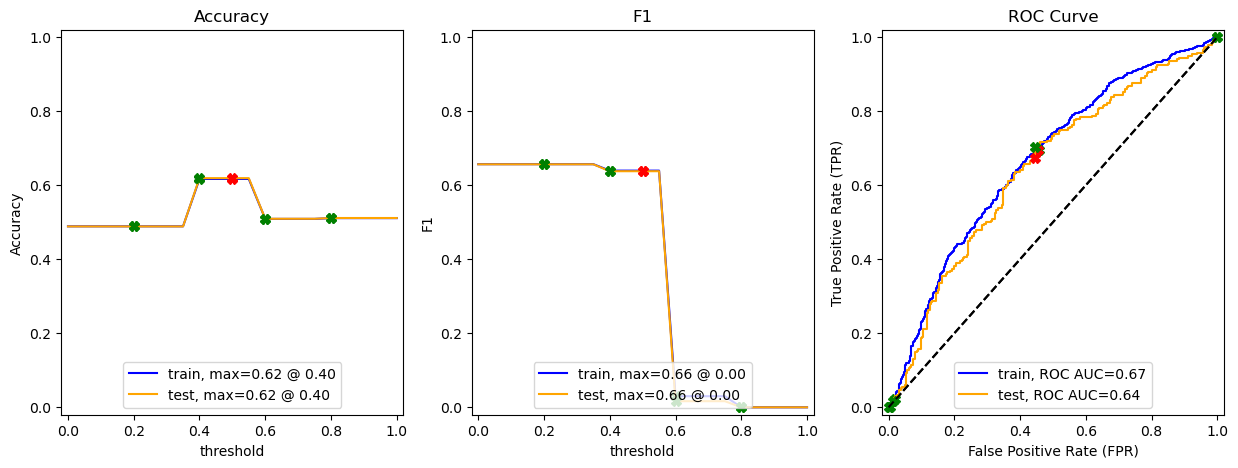

In [50]:
%%time
# Entrenamiento del modelo SVC con los mejores hiperparámetros encontrados en params_svc
model_svc = SVC(
    random_state=12345,
    C=1.0,
    kernel='linear',
    gamma='scale',
    degree=3,
    coef0=0.0,
    probability=True  # Necesario para obtener probabilidades de predicción
)
# Entrenar el modelo
model_svc.fit(X_train, y_train)  
       
# Evaluación del modelo
result_svc = model_evaluator(model_svc, X_train, y_train, X_test, y_test)   

## Modelo 5: XGBClassifier

In [51]:
# Tuning hyperparameters:
# params_xgb = grid_search_cv(XGBClassifier(random_state=12345), params_xgb, X_train, y_train)

,accuracy,f1,roc_auc
group,,,
train,0.69,0.68,0.78
test,0.58,0.53,0.62


CPU times: user 2.22 s, sys: 67.8 ms, total: 2.29 s
Wall time: 470 ms


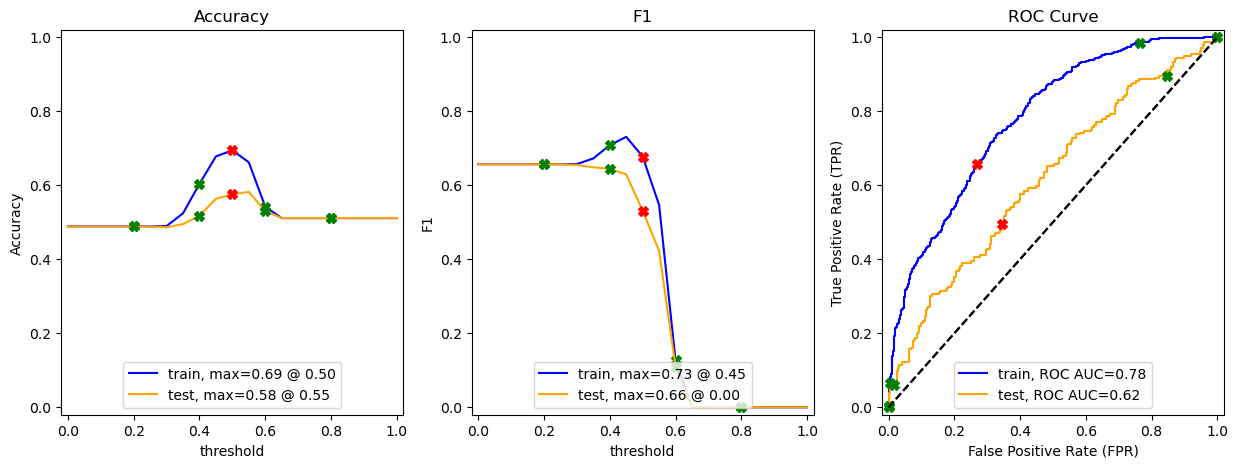

In [52]:
%%time
# Entrenamiento del modelo XGBClassifier con los mejores hiperparámetros encontrados en params_xgb
model_xgb = XGBClassifier(
    random_state=12345,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.5,
    colsample_bytree=0.5,
)
# Entrenar el modelo
model_xgb.fit(X_train, y_train)
# Evaluación del modelo
result_xgb = model_evaluator(model_xgb, X_train, y_train, X_test, y_test)

Revisamos todos los resultados a continuación:

In [53]:
# Crear un DataFrame para guardar los resultados de los modelos

# Definir una lista de tuplas con el nombre del modelo, el modelo en sí y los resultados
models = [
    ('LogisticRegression', model_lr, result_lr),
    ('DecisionTreeClassifier', model_dt, result_dt),
    ('RandomForestClassifier', model_rf, result_rf),
    ('SVC', model_svc, result_svc),
    ('XGBClassifier', model_xgb, result_xgb),]

results = []
for name, model, results_df in models:
    for env in ['train', 'test']:
        results.append({
            'model': name,
            'env': env,
            'accuracy': results_df.loc[env, 'accuracy'],
            'f1': results_df.loc[env, 'f1'],
            'roc_auc': results_df.loc[env, 'roc_auc'],
            'parameters': model.get_params()
        })

all_models = pd.DataFrame(results).set_index(['model', 'env'])

display(all_models)

accuracy    f1  roc_auc  \
model                  env                              
LogisticRegression     train      0.62  0.63     0.68   
                       test       0.59  0.59     0.63   
DecisionTreeClassifier train      0.66  0.65     0.71   
                       test       0.55  0.52     0.59   
RandomForestClassifier train      0.67  0.65     0.76   
                       test       0.60  0.55     0.64   
SVC                    train      0.62  0.64     0.67   
                       test       0.62  0.64     0.64   
XGBClassifier          train      0.69  0.68     0.78   
                       test       0.58  0.53     0.62   

                                                                     parameters  
model                  env                                                       
LogisticRegression     train  {'C': 1.0, 'class_weight': None, 'dual': False...  
                       test   {'C': 1.0, 'class_weight': None, 'dual': False...  
DecisionTreeClassifier train  {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
                       test   {'ccp_alpha': 0.0, 'class_weight': None, 'crit...  
RandomForestClassifier train  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
                       test   {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...  
SVC                    train  {'C': 1.0, 'break_ties': False, 'cache_size': ...  
                       test   {'C': 1.0, 'break_ties': False, 'cache_size': ...  
XGBClassifier          train  {'objective': 'binary:logistic', 'base_score':...  
                       test   {'objective': 'binary:logistic', 'base_score':...

## Análisis y selección del mejor modelo

1.  Comparación de *accuracy*, *f1* y *roc_auc* entre *train* y *test* para cada modelo
2.  Detección de sobreajuste: Si las métricas en *train* son mucho mayores que en *test*, hay sobreajuste.
3.  Selección del mejor modelo: Se prefiere el modelo con mejor desempeño en test, especialmente en *roc_auc* y *f1*.

In [54]:
analysis = []

for model_name in all_models.index.get_level_values(0).unique():
    train = all_models.loc[(model_name, 'train')]
    test = all_models.loc[(model_name, 'test')]
    diff_acc = train['accuracy'] - test['accuracy']
    diff_f1 = train['f1'] - test['f1']
    diff_auc = train['roc_auc'] - test['roc_auc']
    overfit = (diff_acc > 0.05) or (diff_f1 > 0.05) or (diff_auc > 0.05)
    analysis.append({
        'Modelo': model_name,
        'Accuracy (train)': train['accuracy'],
        'Accuracy (test)': test['accuracy'],
        'F1 (train)': train['f1'],
        'F1 (test)': test['f1'],
        'ROC_AUC (train)': train['roc_auc'],
        'ROC_AUC (test)': test['roc_auc'],
        'Sobreajuste': 'Sí' if overfit else 'No'
    })

analysis_df = pd.DataFrame(analysis)
display(analysis_df)

,Modelo,Accuracy (train),Accuracy (test),F1 (train),F1 (test),ROC_AUC (train),ROC_AUC (test),Sobreajuste
0,LogisticRegression,0.62,0.59,0.63,0.59,0.68,0.63,Sí
1,DecisionTreeClassifier,0.66,0.55,0.65,0.52,0.71,0.59,Sí
2,RandomForestClassifier,0.67,0.60,0.65,0.55,0.76,0.64,Sí
3,SVC,0.62,0.62,0.64,0.64,0.67,0.64,No
4,XGBClassifier,0.69,0.58,0.68,0.53,0.78,0.62,Sí


**Análisis:**
- El modelo SVC es el único que no presenta sobreajuste ("Sobreajuste" = 'No').
- SVC tiene valores de accuracy, F1 y ROC_AUC similares en train y test, lo que indica buena generalización.
- Aunque otros modelos como XGBClassifier y RandomForestClassifier tienen métricas más altas en entrenamiento, su desempeño cae notablemente en test, mostrando sobreajuste.
- SVC obtiene en test: ``accuracy=0.62``, ``F1=0.64``, ``ROC_AUC=0.64``, lo que lo posiciona como el más equilibrado y robusto.

**Conclusión:**

El mejor modelo es ``SVC``, ya que logra el mejor equilibrio entre desempeño y generalización, con métricas similares en entrenamiento y prueba, y sin evidencia de sobreajuste.
